## Notebook for fixing simulation setting, network structure and demographic parameters

In [1]:
# Import librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from collections import Counter

In [2]:
# Set seed
np.random.seed(100)

In [3]:
#### Trade network function definition #

def create_edges_nbfils(L, power, tries = 1000000):  

    ''' Function for simulating a directed weighted powerlaw graph with weights = 1 all'''

    # Generate de out-degree = in-degree sequence with the given power
    p= list(1 / (np.array(range(1, L)))**power) 
    p = p/sum(p)
    out_degs = list(np.random.choice(range(1, L), L, replace = True, p = p))

    # We correct the degree sequence if its sum is odd
    if (sum(out_degs) % 2 != 0):
        out_degs[0] = out_degs[0] + 1 

    # Generate directed graph with the given out-degree = in-degree sequence 
    g = igraph.Graph.Degree_Sequence(out_degs, out_degs, method="simple")
    g = g.simplify(multiple=True, loops=True) # remove loops or multiple edges

    print('Power:', power)
    g.es["weight"] = 1 # the graph is also weighted , the weights will later be modified

    edges = []
    weights = []
    for e in g.es:
        edges.append(e.tuple)
        weights.append(e["weight"])
    edges = np.array(edges)
    weights = np.array(weights)

    # Array with list f edges and weights. Columns: i,j,theta_ij
    theta_edges = np.hstack((edges, np.zeros((edges.shape[0], 1))))
    theta_edges[:,2] = weights 
    theta_edges = theta_edges.astype(float)
    theta_edges[:,2] = 1

    return np.array(theta_edges)

## FIXED PARAMETERS 

In [4]:
# Total number of herds
L = 5000 

# Fixed graph structure with the given porwer-law (weights will be defined later)
power = 2
theta_edges = create_edges_nbfils(L, power)

# Simulation setting
delta = 0.5 # simulation step
nb_years = 3 # number of years to simulate
nb_steps = int(365/delta*nb_years) # length of each trajectory

# Demographic parameters: mu (birth rate) and tau (death rate)
demo_params = np.array([[1/(365*1.5), 1/(365*3)]]*L) 

print('Number of herds:', L)
print('Simulation step delta:', delta)
print('Simulated years:', nb_years)
print('Demographic parameters (mu and tau):', demo_params[0])

Power: 2
Number of herds: 5000
Simulation step delta: 0.5
Simulated years: 3
Demographic parameters (mu and tau): [0.00182648 0.00091324]


## SIMULATION OF POPULATION STRUCTURE 

In [5]:
# First we check that every node has a buyer and seller at least, if not we 
# add a neighbor for herds without buyers, or sellers 
# indeed, if the neighbor was itself, maybe it has no neighbor

def find_missing(lst): 
    return [x for x in range(0, L)
                               if x not in lst] 

sorted_receveirs =  sorted(theta_edges[:,1].astype(int))
non_receveirs = find_missing(sorted_receveirs)
theta_edges = list(theta_edges)
for i in non_receveirs:
    if i == 0:
        theta_edges.append(np.array([i+1, i, 1]))
    else:
        theta_edges.append(np.array([i-1, i, 1])) 
theta_edges = np.array(theta_edges)

sorted_givers =  sorted(theta_edges[:,0].astype(int))
non_givers = find_missing(sorted_givers)
theta_edges = list(theta_edges)
for i in non_givers:
    if i == 0:
        theta_edges.append(np.array([i, i+1, 1]))
    else:
        theta_edges.append(np.array([i, i-1, 1])) 
theta_edges = np.array(theta_edges)

In [6]:
print('Aditionally created in-edges:', len(non_receveirs))
print('Additionally created out-edges:', len(non_givers))

Aditionally created in-edges: 0
Additionally created out-edges: 0


In [7]:
# Degrees data frames
a = []
b = []
for i in range(L):
    a.append(np.sum(theta_edges[:,1] == i))
    b.append(np.sum(theta_edges[:,0] == i))
in_deg = np.array(a)
out_deg = np.array(b)
in_deg_pd = pd.DataFrame(in_deg)
out_deg_pd = pd.DataFrame(out_deg)


In [8]:
# Theta edges as graph to plot and compute shortest lengths 
edges = theta_edges[:, :2].astype(int).tolist()
edges = [[str(j) for j in i] for i in edges]

# collect the set of vertex names and then sort them into a list
vertices = set()
for line in edges:
    vertices.update(line)
vertices = sorted(vertices)

# create an empty graph
g = igraph.Graph(directed = True)

# add vertices to the graph
g.add_vertices(vertices)

# add edges to the graph
g.add_edges(edges)

# set the weight of every edge to 1
g.es["weight"] = 1

# collapse multiple edges and sum their weights
g.simplify(combine_edges={"weight": "sum"})

for v in g.vs:
    v["value"] = v.index

g.vs["label"] = g.vs["value"]
# To plot:
#out_fig_name = "graph.eps"
#layout = g.layout("kk")
#plot(g, out_fig_name,layout = layout)

shortest_paths = np.array(g.shortest_paths_dijkstra(weights=None, mode="in"))



# Generate initial size herds
N0s = np.random.gamma(9,12, L)
N0s = N0s.astype(int)
N0s_pd = pd.DataFrame(N0s)

# Assign sizes according to out degree:
df_out_degrees = pd.DataFrame(out_deg)#sort thetas_i from small to big
df_out_degrees['indegree']  = in_deg # add indeg to the database too
N0s_pd  = N0s_pd.sort_values(0) 
sorted_bygroup_N0s = np.array(N0s_pd[0])
df_out_degrees  = df_out_degrees.sort_values(0) # Data frame de degrees avec N0s
df_out_degrees['N0s'] = sorted_bygroup_N0s
df_out_degrees = df_out_degrees.sort_index()

# Simulate out rates theta_i
p=list(1 / (np.array(np.arange(0.0006,  1, 0.000001)))**power) 
p = p/sum(p)
out_thetas = list(np.random.choice(np.arange(0.0006, 1,  0.000001), L, replace = True, p = p)) 
out_thetas = pd.DataFrame(out_thetas)

# Assign theta_i according to out-degree
out_thetas  = out_thetas.sort_values(0) #sort thetas_i from small to big
sorted_bygroup_thetas_i = np.array(out_thetas[0])
df_out_degrees  = df_out_degrees.sort_values(0)
df_out_degrees['theta_i'] = sorted_bygroup_thetas_i
df_out_degrees = df_out_degrees.sort_index()

# Distribute theta_i among child nodes (buyers) to obtain the theta_ij
for i in range(0,L):
    ijw = theta_edges[theta_edges[:,0] == i, :] 
    neighb_i = ijw[:,1].astype(int)
    theta_i_out = np.array(df_out_degrees['theta_i'])[i]
    outdeg_neighi = out_deg[neighb_i]
    indeg_neighi = in_deg[neighb_i]
    sizes_neighi = N0s[neighb_i]
    theta_neighi_out = np.array(df_out_degrees['theta_i'])[tuple([neighb_i])]
    theta_prime = (theta_neighi_out + shortest_paths[i, neighb_i])/indeg_neighi  # inversely proportional to the in-degree 
    theta_i_neighi = theta_prime * theta_i_out / np.sum(theta_prime)
    theta_edges[theta_edges[:,0] == i, 2] = theta_i_neighi
theta_pd = pd.DataFrame(theta_edges)


## Plots In(Out) Degree and Initial Herd size distribution 

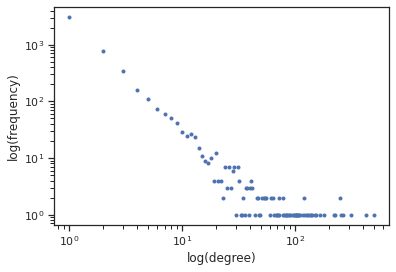

<Figure size 432x288 with 0 Axes>

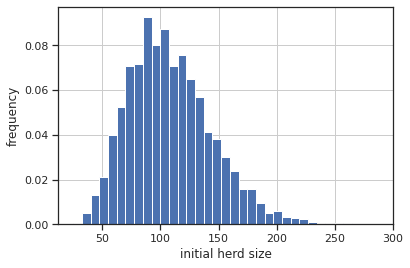

In [9]:
# Plot histogram of in_degree and out-degree, in log

degrees = in_deg
degree_counts = Counter(degrees)                                                                                                 
x, y = zip(*degree_counts.items())                                                      

plt.figure(1)   

# prep axes                                                                                                                      
plt.xlabel('log(degree)')                                                                                                             
plt.xscale('log')           

plt.ylabel('log(frequency)')                                                                                                          
plt.yscale('log')                                                                                                                                   
plt.scatter(x, y, marker='.')     
plt.savefig('degree_simulated.pdf',bbox_inches = 'tight') 
plt.show()


# Plot Initial herd sizes
plt.figure()
N0s_pd.hist(bins =35,  weights=np.zeros_like(N0s_pd) + 1. / N0s_pd.size)
plt.title('')
plt.xlabel('initial herd size')
plt.ylabel('frequency')
plt.show()

## Save fixed parameters

In [10]:
#Save initial number of animals by herd
np.savetxt('N0s.txt', N0s)

#Save setting (delta and nb-steps)
setting = np.array([delta, nb_steps])
np.savetxt('setting.txt', setting)

#Save demo_params
np.savetxt('demo_params.txt', demo_params)

#Save theta_edges
np.savetxt('theta_edges.txt', theta_edges)